# Document Extraction - _continued_

In this notebook, we will train an Amazon Comprehend custom entity recognizer so that we can detect and extract entities from a sample Hospital Discharge Summary. We will be using the [Amazon Textract Parser Library](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python) to extract the plaintext data from the document and use data science library [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to prepare training data. We will also be needing the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), and [AWS boto3 python sdk](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) libraries. We will perform two types of entity recognition with Amazon Comprehend.

- [Default entity recognition](#step1)
- [Custom entity recognition](#step2)

---

## Setup Notebook


In [1]:
import boto3
import botocore
import sagemaker
import time
import os
import json
import datetime
import io
import uuid
import pandas as pd
import numpy as np
from pytz import timezone
from PIL import Image, ImageDraw, ImageFont
import multiprocessing as mp
from pathlib import Path
from IPython.display import Image, display, HTML, JSON, IFrame
from textractcaller.t_call import call_textract, Textract_Features
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string
from trp import Document

# Document
from IPython.display import Image, display, HTML, JSON
from PIL import Image as PImage, ImageDraw


# variables
data_bucket = sagemaker.Session().default_bucket()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

os.environ["BUCKET"] = data_bucket
os.environ["REGION"] = region
role = sagemaker.get_execution_role()

print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

s3=boto3.client('s3')
textract = boto3.client('textract', region_name=region)
comprehend=boto3.client('comprehend', region_name=region)


SageMaker role is: arn:aws:iam::159664259931:role/IDPCfnStack-SageMakerExecutionRole-1NZJF84HAQF6I
Default SageMaker Bucket: s3://sagemaker-us-east-2-159664259931


---
# Default Entity Recognition with Amazon Comprehend <a id="step1"></a>

Amazon Comprehend can detect a pre-defined list of default entities using it's pre-trained model. Check out the [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-entities.html) for a full list of default entitied. In this section, we will see how we can use Amazon Comprehend's default entity recognizer to get the default entities present in the document.

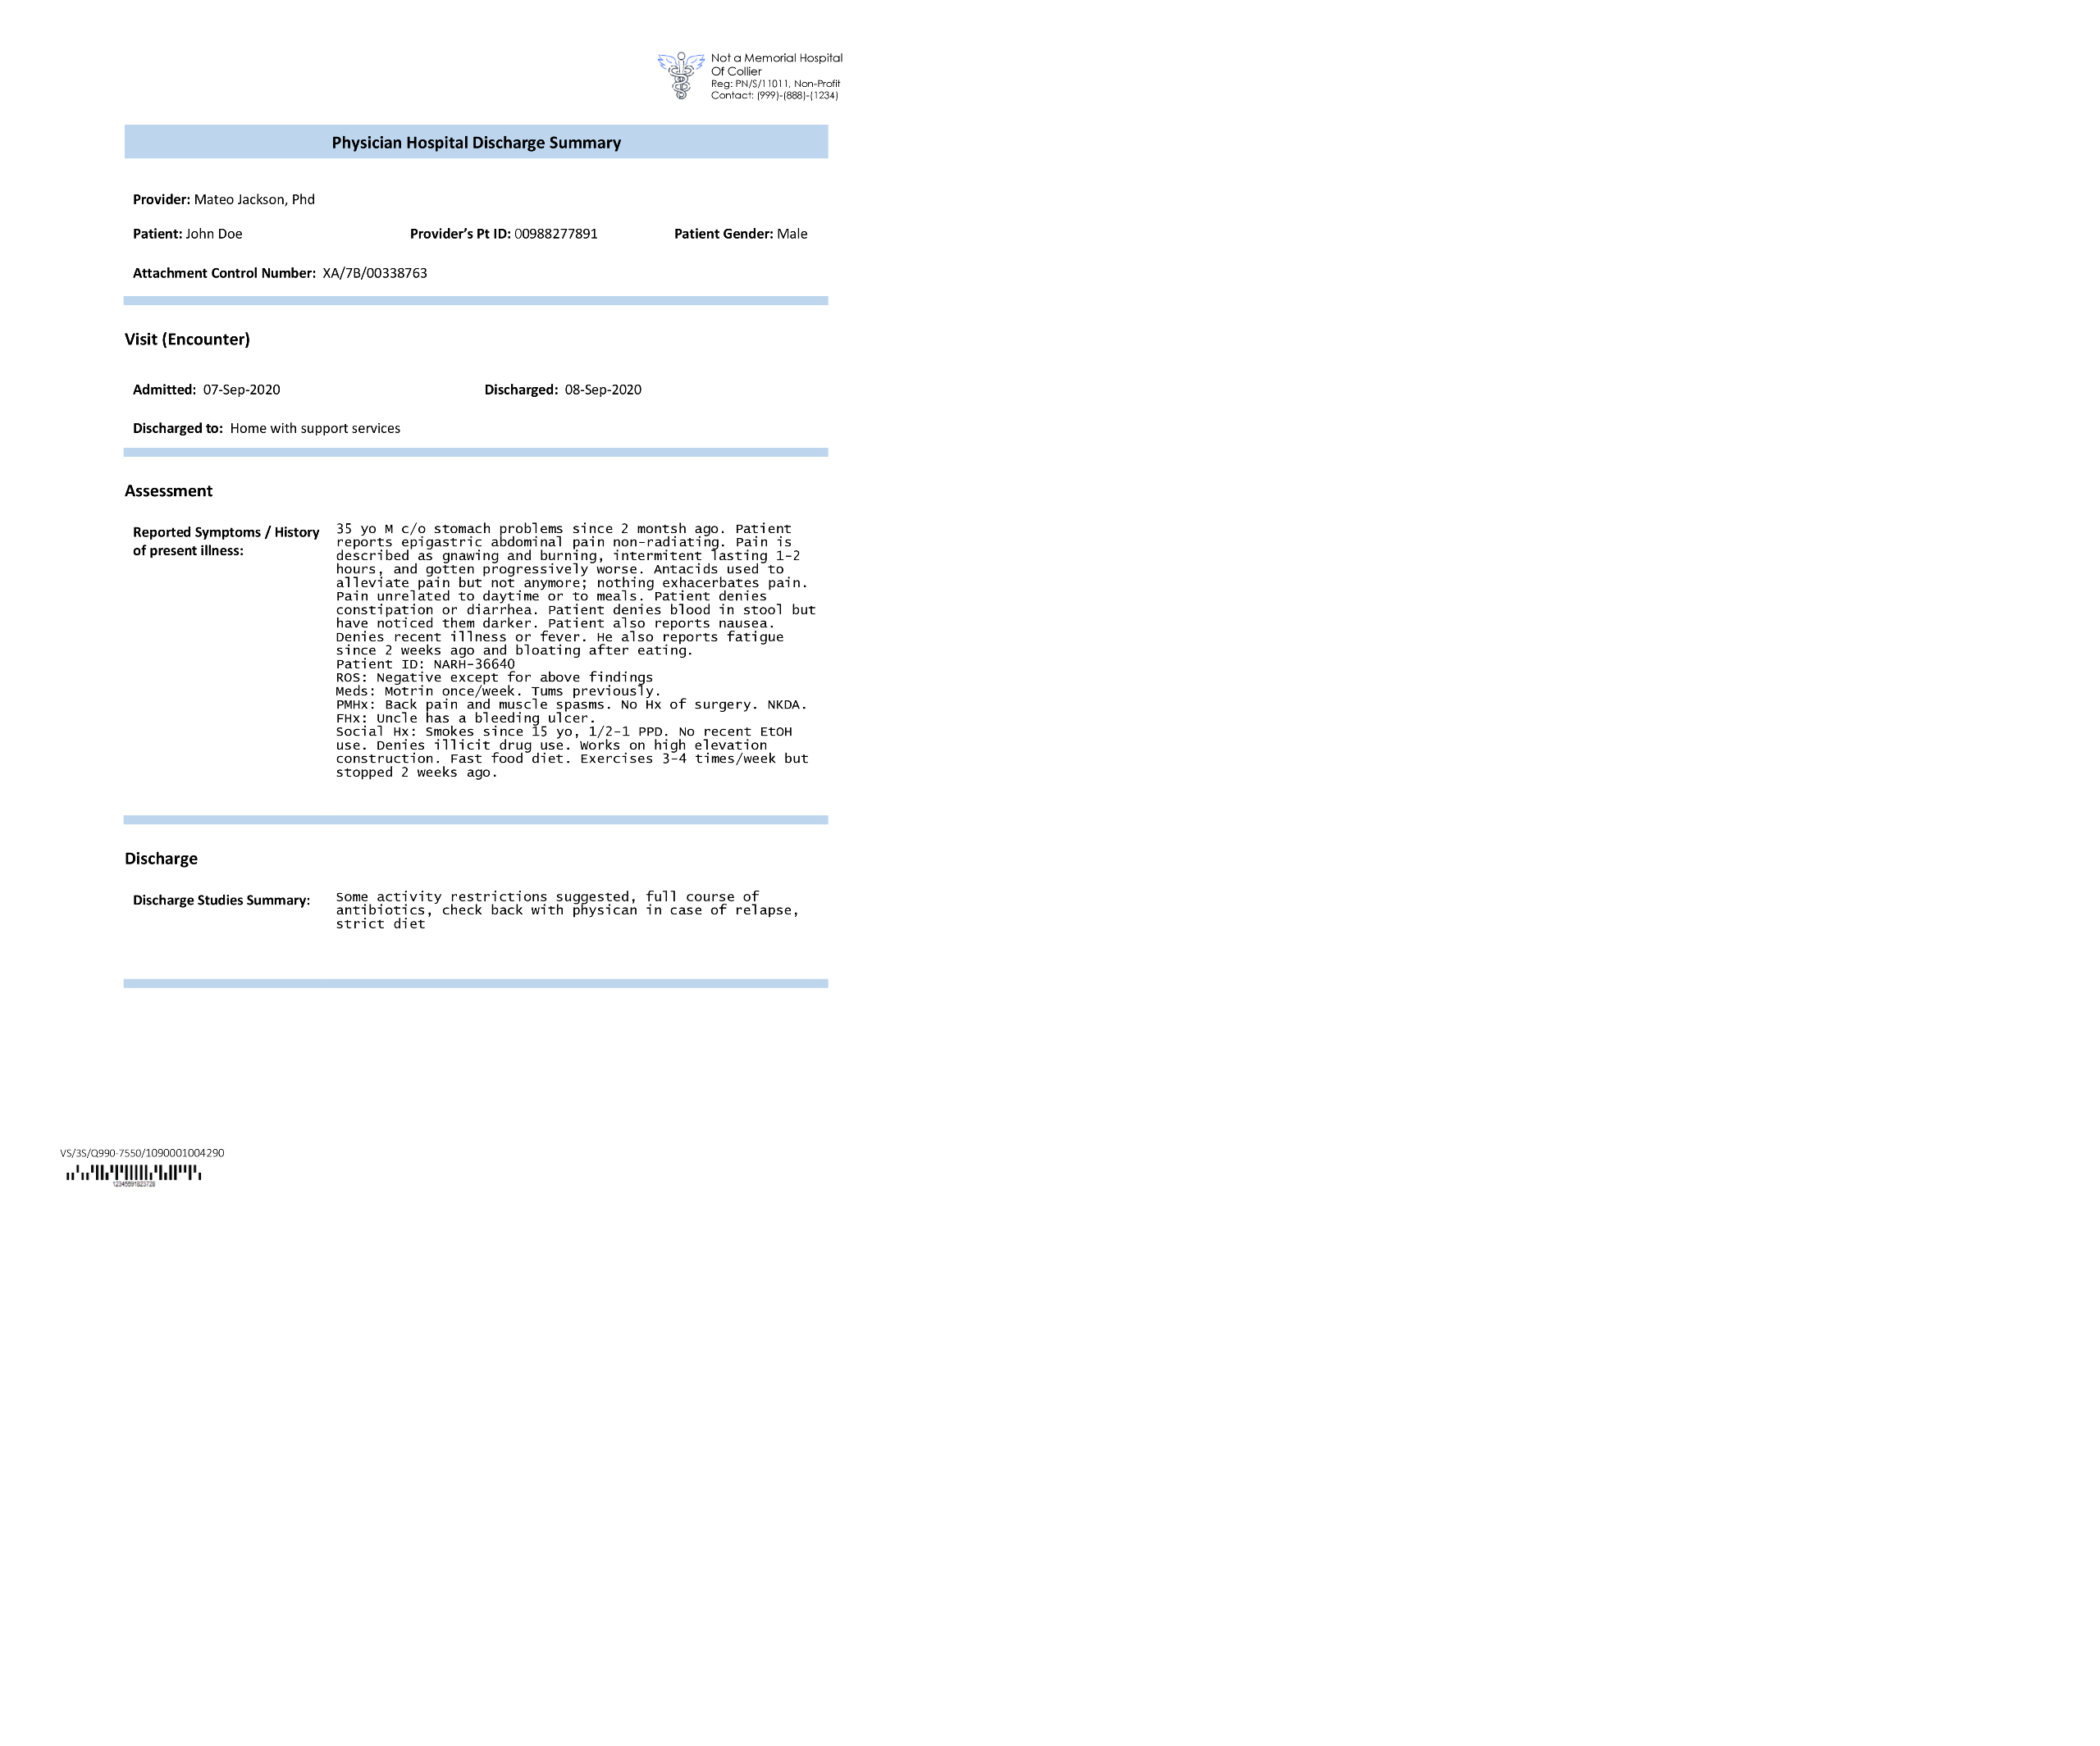

In [24]:
# document path for the discharge summary in dataset

display(Image(filename="./dataset/document_samples/discharge-summary.png", width=900, height=400))

Let's now take a look at some of the features available within Comprehend Medical.

In [25]:
#upload to S3
key='idp/textract/discharge_summary.png'
s3.upload_file(Filename='./dataset/document_samples/discharge-summary.png', 
               Bucket=data_bucket, 
               Key=key)

In [5]:
form_resp = textract.analyze_document(Document={'S3Object':{"Bucket": data_bucket, "Name": key}
    }, FeatureTypes=['TABLES','FORMS'])

In [6]:
# Print text
print("\nText\n========")
text = ""
for item in form_resp["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


Text
Not a Memorial Hospital
Of Collier
Reg: PN/S/1 1011 Non-Profit
Contact (999)-(888)-(1234)
Physician Hospital Discharge Summary
Provider: Mateo Jackson, Phd
Patient: John Doe
Provider's Pt ID: 00988277891
Patient Gender: Male
Attachment Control Number: XA/7B/00338763
Visit (Encounter)
Admitted: 07-Sep-2020
Discharged: 08-Sep-2020
Discharged to: Home with support services
Assessment
Reported Symptoms / History
35 yo M c/o stomach problems since 2 montsh ago. Patient
reports epigastric abdominal pain non-radiating. Pain is
of present illness:
described as gnawing and burning, intermitent lasting 1-2
hours and gotten progressively worse. Antacids used to
alleviate pain but not anymore; nothing exhacerbates pain.
Pain unrelated to daytime or to meals. Patient denies
constipation or diarrhea. Patient denies blood in stool but
have noticed them darker Patient also reports nausea.
Denies recent illness or fever. He also reports fatigue
since 2 weeks ago and bloating after eating.
Patient

In [7]:
comprehend_med = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehend_med.detect_entities_v2(Text=text)

print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- Memorial Hospital
   Type: ADDRESS
   Category: PROTECTED_HEALTH_INFORMATION


- (999)-(888)-(1234
   Type: PHONE_OR_FAX
   Category: PROTECTED_HEALTH_INFORMATION


- Mateo Jackson
   Type: NAME
   Category: PROTECTED_HEALTH_INFORMATION


- John Doe
   Type: NAME
   Category: PROTECTED_HEALTH_INFORMATION


- 00988277891
   Type: ID
   Category: PROTECTED_HEALTH_INFORMATION


- 00338763
   Type: ID
   Category: PROTECTED_HEALTH_INFORMATION


- 07-Sep-2020
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- 08-Sep-2020
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- 35
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- stomach
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- stomach problems
   Type: DX_NAME
   Category: MEDICAL_CONDITION


- epigastric
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- epigastric abdominal pain
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- abdominal
   Type: SYSTEM_ORGAN_

In [8]:
cm_json_data =  comprehend_med.infer_icd10_cm(Text=text)

print("\nMedical coding\n========")

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        description = icd['Description']
        code = icd["Code"]
        print(f'{description}: {code}')
            



Medical coding
Disease of stomach and duodenum, unspecified: K31.9
Other diseases of stomach and duodenum: K31.89
Unspecified symptoms and signs involving the genitourinary system: R39.9
Other specified symptoms and signs involving the digestive system and abdomen: R19.8
Other symptoms and signs involving the genitourinary system: R39.89
Epigastric pain: R10.13
Unspecified abdominal pain: R10.9
Epigastric abdominal tenderness: R10.816
Functional dyspepsia: K30
Epigastric abdominal rigidity: R19.36
Unspecified foreign body in bronchus causing asphyxiation: T17.500
Unspecified foreign body in trachea causing asphyxiation: T17.400
Urban rabies: A82.1
Unspecified foreign body in pharynx causing asphyxiation: T17.200
Unspecified foreign body in pharynx causing asphyxiation, initial encounter: T17.200A
Other disturbances of skin sensation: R20.8
Unspecified disturbances of skin sensation: R20.9
Painful ejaculation: N53.12
Disturbances of skin sensation: R20
Chronic nasopharyngitis: J31.1
Pa

We will now extract the (UTF-8) string text from the document above and use the Amazon Comprehend [DetectEntities](https://docs.aws.amazon.com/comprehend/latest/dg/API_DetectEntities.html) API to detect the default entities.


In [9]:
comprehend = boto3.client('comprehend')

response = comprehend.detect_entities(
    Text=text,
    LanguageCode='en')

In [10]:
for entity in response['Entities']:
    print(f'{entity["Type"]} : {entity["Text"]}')

ORGANIZATION : Memorial Hospital Of Collier
OTHER : PN/S/1 1011
OTHER : (999)-(888)
OTHER : (1234
PERSON : Mateo Jackson
PERSON : John Doe
OTHER : 00988277891
OTHER : XA/7B/00338763
DATE : 07-Sep-2020
DATE : 08-Sep-2020
QUANTITY : 35 yo
DATE : 2 montsh ago
QUANTITY : 1-2 hours
DATE : 2 weeks ago
OTHER : NARH-36640 ROS
QUANTITY : once/week
QUANTITY : 15 yo
QUANTITY : PPD
QUANTITY : 3-4 times/week
DATE : 2 weeks ago



The output above shows us the default entities that Amazon Comprehend was able to detect in the document's text. However, we are interested in knowing specific entity values such as the patient name (which is denoted currently by default entity PERSON), or the patient's ID (which is denoted currently by default entity OTHER). In order to be able to do that, we will need to train an Amazon Comprehend custom entity recognizer which we will do in the following section

---
# Custom Entity Recognition with Amazon Comprehend <a id="step2"></a>

## Data preparation

There are 2 different ways we can train an Amazon Comprehend  custom entity recognizer. 

- [Annotations](https://docs.aws.amazon.com/comprehend/latest/dg/cer-annotation.html)
- [Entity lists](https://docs.aws.amazon.com/comprehend/latest/dg/cer-entity-list.html)

The annotations method can often lead to more refined results for image files, PDFs, or Word documents because you train a model by submitting more accurate context as annotations along with your documents. However, the annotations method can be time-consuming and work-intensive.

For simplicity of this hands-on, we use the entity lists method, which you can only use for plain text documents. This method gives us a CSV file that should contain the plain text and its corresponding entity type, as shown in the preceding example. The entities in this file are going to be specific to our use case, here - patient name and patient ID.

For more details on how to prepare the training data for different use cases using annotations or entity lists methods, refer to [Preparing the training data.](https://docs.aws.amazon.com/comprehend/latest/dg/prep-training-data-cer.html)


Now, let's take a look at our sample document.

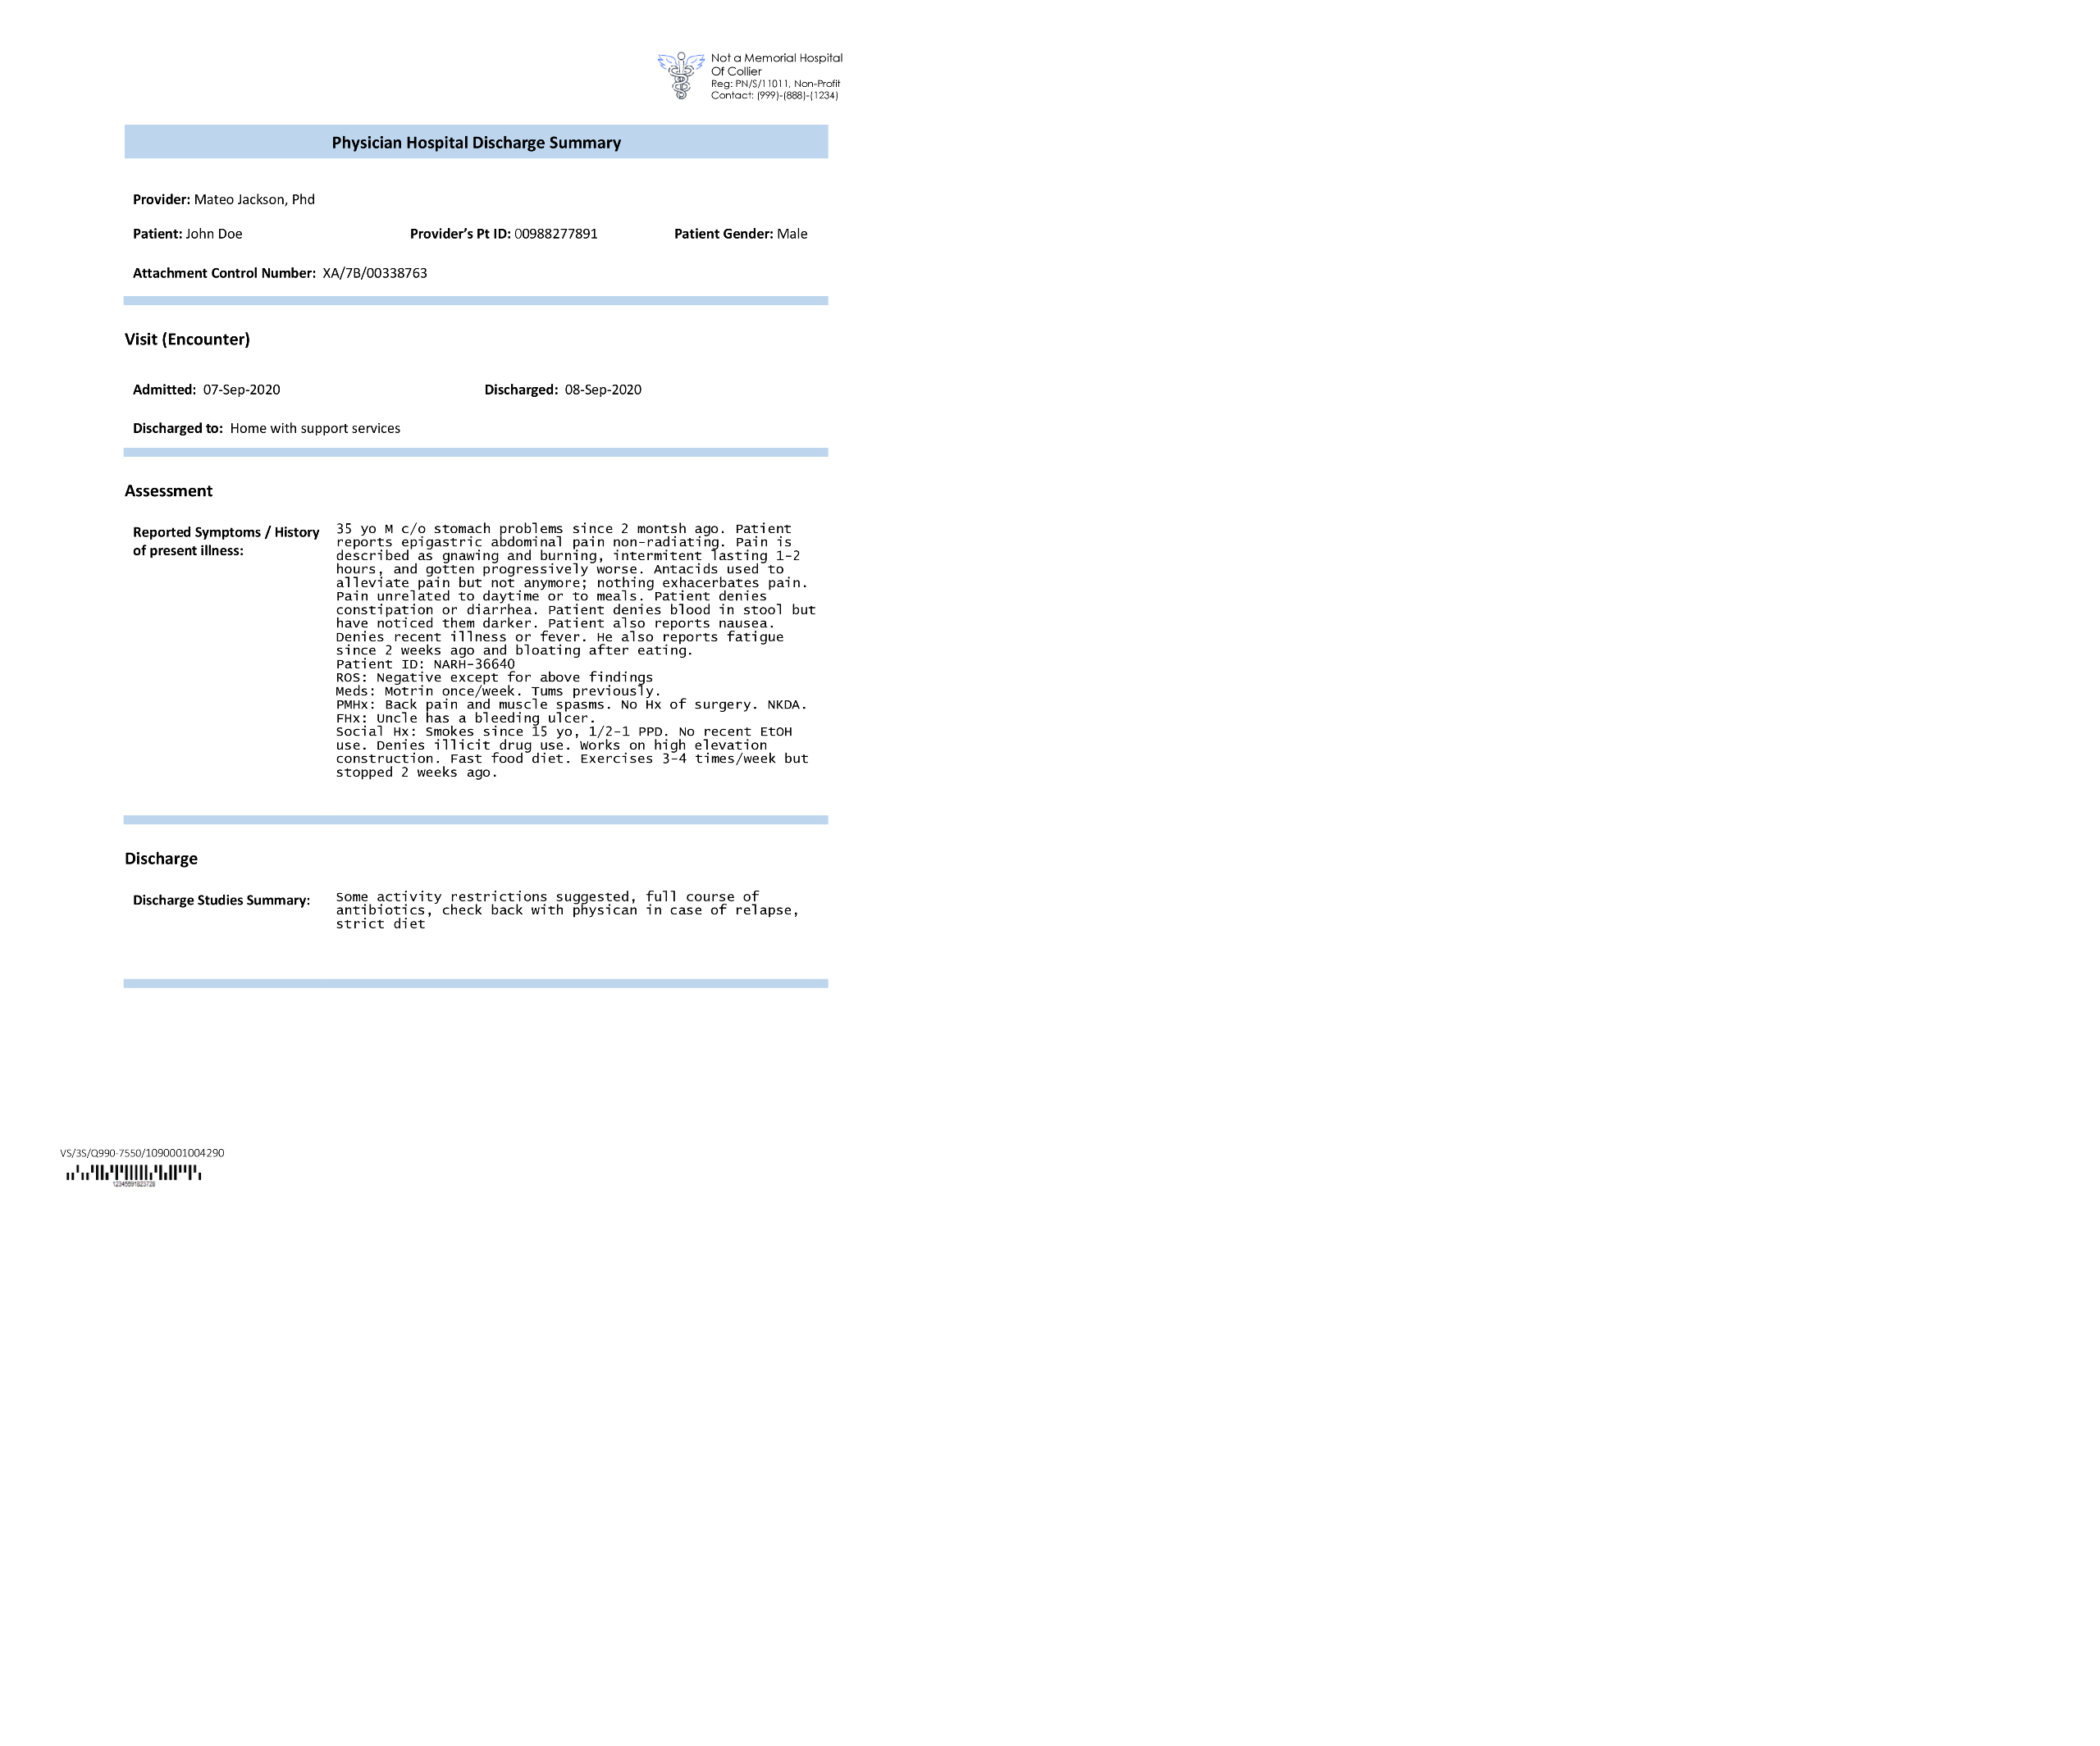

In [26]:
display(Image(filename="./dataset/document_samples/discharge-summary.png", width=900, height=400))

We would like to extract 2 entities from this document

- Patient name (`PATIENT_NAME`)
- Patient ID (`PATIENT_ID`)

Since we are going to use and Entity List with the above two entities, we need to get the sample document's content in UTF-8 encoded plain text format. This can be done by extracting the text from the document file(s) using Amazon textract.

In [12]:
response = call_textract(input_document=f's3://{data_bucket}/idp/textract/discharge_summary.png') 
lines = get_string(textract_json=response, output_type=[Textract_Pretty_Print.LINES])
text = lines.replace("\n", " ")
text

"Not a Memorial Hospital Of Collier Reg: PN/S/1 1011 Non-Profit Contact (999)-(888)-(1234) Physician Hospital Discharge Summary Provider: Mateo Jackson, Phd Patient: John Doe Provider's Pt ID: 00988277891 Patient Gender: Male Attachment Control Number: XA/7B/00338763 Visit (Encounter) Admitted: 07-Sep-2020 Discharged: 08-Sep-2020 Discharged to: Home with support services Assessment Reported Symptoms / History 35 yo M c/o stomach problems since 2 montsh ago. Patient reports epigastric abdominal pain non-radiating. Pain is of present illness: described as gnawing and burning, intermitent lasting 1-2 hours and gotten progressively worse. Antacids used to alleviate pain but not anymore; nothing exhacerbates pain. Pain unrelated to daytime or to meals. Patient denies constipation or diarrhea. Patient denies blood in stool but have noticed them darker Patient also reports nausea. Denies recent illness or fever. He also reports fatigue since 2 weeks ago and bloating after eating. Patient ID: 

The custom entity recognizer needs atleast 200 document samples, and 250 entity samples for each entity. For the purposes of this hands-on we have provided the augmented manifest file that provide training data for your custom model. An augmented manifest file is a labeled dataset that is produced by Amazon SageMaker Ground Truth.


---

## Training the custom entity recognizer

Let's take a look at the entity list csv file.

In [13]:
entities_df = pd.read_csv('./dataset/entity_list.csv', dtype={'Text': object})
entities = entities_df["Type"].unique().tolist()
print(f'Custom entities : {entities}')
print(f'\nTotal Custom entities: {entities_df["Type"].nunique()}')
print("\n\nTotal Sample per entity:")
entities_df['Type'].value_counts()

Custom entities : ['PATIENT_ID', 'PATIENT_NAME']

Total Custom entities: 2


Total Sample per entity:


PATIENT_ID      300
PATIENT_NAME    300
Name: Type, dtype: int64

Here, we have two types of entities in the entity list CSV file - `PATIENT_ID` and `PATIENT_NAME`. We also have 300 samples for each entity. With the minimum number of samples per entity satisfied, we can now train the custom entity recognizer model for Amazon Comprehend. Let's upload entity list CSV file and the raw text corpus of the training data to S3.

In [14]:
!aws s3 cp ./dataset/entity_list.csv s3://{data_bucket}/idp-insurance/comprehend/entity_list.csv
!aws s3 cp ./dataset/entity_training_corpus.txt s3://{data_bucket}/idp-insurance/comprehend/entity_training_corpus.txt

upload: dataset/entity_list.csv to s3://sagemaker-us-east-2-159664259931/idp-insurance/comprehend/entity_list.csv
upload: dataset/entity_training_corpus.txt to s3://sagemaker-us-east-2-159664259931/idp-insurance/comprehend/entity_training_corpus.txt


Let's initialize the variables required to start the entity recognizer training job.

In [15]:
entities_uri = f's3://{data_bucket}/idp-insurance/comprehend/entity_list.csv'
training_data_uri = f's3://{data_bucket}/idp-insurance/comprehend/entity_training_corpus.txt'

print(f'Entity List CSV File: {entities_uri}')
print(f'Training Data File: {training_data_uri}')

Entity List CSV File: s3://sagemaker-us-east-2-159664259931/idp-insurance/comprehend/entity_list.csv
Training Data File: s3://sagemaker-us-east-2-159664259931/idp-insurance/comprehend/entity_training_corpus.txt


In [ ]:
# Create a custom entity recognizer
account_id = boto3.client('sts').get_caller_identity().get('Account')
id = str(datetime.datetime.now().strftime("%s"))

entity_recognizer_name = 'insurance-custom-ner-ds'
entity_recognizer_version = 'v1'
entity_recognizer_arn = ''
create_response = None
EntityTypes = []
for e in entities:
    EntityTypes.append( {'Type':e})

In [17]:
try:
    create_response = comprehend.create_entity_recognizer(
        InputDataConfig={
            'DataFormat': 'COMPREHEND_CSV',
            'EntityTypes': EntityTypes,
            'Documents': {
                'S3Uri': training_data_uri
            },
            'EntityList': {
                'S3Uri': entities_uri
            }
        },
        DataAccessRoleArn=role,
        RecognizerName=entity_recognizer_name,
        VersionName=entity_recognizer_version,
        LanguageCode='en'
    )
    
    entity_recognizer_arn = create_response['EntityRecognizerArn']
    
    print(f"Comprehend Custom entity recognizer created with ARN: {entity_recognizer_arn}")
except Exception as error:

    print(error)

Comprehend Custom entity recognizer created with ARN: arn:aws:comprehend:us-east-2:159664259931:entity-recognizer/insurance-custom-ner-transcription/version/v1


Check status of the Comprehend Custom Classification Job. Alternatively, the status of the training job can also be viewed by going to the Amazon Comprehend console.
Note that the training may take ~ 30 minutes. 

Once the training job is completed move on to next step.

In [18]:
%%time
# Loop through and wait for the training to complete . Takes up to 10 mins 
from IPython.display import clear_output
import time
from datetime import datetime

jobArn = create_response['EntityRecognizerArn']

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    describe_custom_recognizer = comprehend.describe_entity_recognizer(
        EntityRecognizerArn = jobArn
    )
    status = describe_custom_recognizer["EntityRecognizerProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom document entity recognizer: {status}")
    
    if status == "TRAINED" or status == "IN_ERROR":
        break
    time.sleep(10)

04:24:04 : Custom document entity recognizer: TRAINED
CPU times: user 1.59 s, sys: 122 ms, total: 1.72 s
Wall time: 20min 28s


---
## Create an Amazon Comprehend custom NER real-time endpoint

Once our model has been trained successfully, it can then be deployed via an endpoint. Let's look at how we can deploy the trained custom entity recognizer.

In [19]:
#create comprehend endpoint
model_arn = entity_recognizer_arn
ep_name = 'insurance-custom-ner-endpoint'

try:
    endpoint_response = comprehend.create_endpoint(
        EndpointName=ep_name,
        ModelArn=model_arn,
        DesiredInferenceUnits=1,    
        DataAccessRoleArn=role
    )
    ER_ENDPOINT_ARN=endpoint_response['EndpointArn']
    print(f'Endpoint created with ARN: {ER_ENDPOINT_ARN}')
    %store ER_ENDPOINT_ARN
except Exception as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print(f'An endpoint with the name "{ep_name}" already exists.')
        ER_ENDPOINT_ARN = f'arn:aws:comprehend:{region}:{account_id}:entity-recognizer-endpoint/{ep_name}'
        print(f'The classifier endpoint ARN is: "{ER_ENDPOINT_ARN}"')
        %store ER_ENDPOINT_ARN
    else:
        print(error)

Endpoint created with ARN: arn:aws:comprehend:us-east-2:159664259931:entity-recognizer-endpoint/insurance-custom-ner-endpoint
Stored 'ER_ENDPOINT_ARN' (str)


Note that the endpoint creation may take about ~ 20 minutes. The status of the deployment can be checked using the code below. You can also view the status of the training job from the Amazon Comprehend console.

In [20]:
%%time
# Loop through and wait for the training to complete . Takes up to 20 mins 
from IPython.display import clear_output
import time
from datetime import datetime

ep_arn = endpoint_response["EndpointArn"]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    describe_endpoint_resp = comprehend.describe_endpoint(
        EndpointArn=ep_arn
    )
    status = describe_endpoint_resp["EndpointProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom entity recognizer classifier: {status}")
    
    if status == "IN_SERVICE" or status == "FAILED":
        break
        
    time.sleep(10)

04:36:51 : Custom entity recognizer classifier: IN_SERVICE
CPU times: user 728 ms, sys: 65.1 ms, total: 793 ms
Wall time: 9min 23s


---

## Detect custom entities using the Endpoint

We will now detect our two custom entities `PATIENT_NAME` and `PATIENT_ID` from our sample discharge summary letter. The function `get_entities()` is a wrapper function that calls the comprehend `DetectEntities` API. To get entities from the sample text document, we call the `comprehend.detect_entities()` method within the wrapper function and configure the language code and text as input parameters. 

In [21]:
def get_entities(text):
    try:
        #detect entities
        entities_custom = comprehend.detect_entities(LanguageCode="en", Text=text, EndpointArn=ER_ENDPOINT_ARN)  
        df_custom = pd.DataFrame(entities_custom["Entities"], columns = ['Text', 'Type', 'Score'])
        df_custom = df_custom.drop_duplicates(subset=['Text']).reset_index()
        return df_custom
    except Exception as e:
        print(e)

The API response that we get are the detected entities, their types and their corresponding confidence scores

In [22]:
response = get_entities(text)
response

,index,Text,Type,Score
0,0,John Doe,PATIENT_NAME,0.999999
1,1,NARH-36640,PATIENT_ID,1.000000


---

# Conclusion

In this notebook, we saw Amazon Comprehend pre-trained entities and an Amazon Comprehend custom entity recognizer for further document extraction. For custom entity recognition, we trained an Amazon Comprehend custom entity recognizer model to detect custom entities from documents containing dense texts. We used the `Entity lists` approach to train the custom ner model, and lastly, deployed the model with an endpoint. We then used the endpoint to detect our custom entities `Patient Name` and `Patient ID` from the text extracted by Amazon Textract, from our sample Discharge Summary document.